Twelveth exercice: Calibrationless CS-pMR image reconstruction from undersampled Cartesian data
================================================================================================

In this tutorial we will reconstruct a 2D MR image from multicoil Cartesian under-sampled kspace measurements.

We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with **calibrationless** multi-coil Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation. **Structured sparsity** will be promoted in the wavelet domain, using either Symmlet-8 (analysis and synthesis) or undecimated bi-orthogonal wavelets (analysis only) considering group-LASSO or OSCAR-based regularization. The multicoil data $(y_\ell)_\ell$ is collected across multiple, say $L$, channels.

We remind that the synthesis formulation of the Calibrationless CS-PMRI problem reads (minimization in the sparsifying domain):
$$
\widehat{Z} = \text{arg}\,\min_{Z\in C^{n_\Psi\times L}} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - \Omega F \Psi^*z_\ell \|_2^2 + \lambda {\cal R}(Z)
$$
where $Z= [z_1, \ldots, z_L]$ and $X = [x_1,\ldots, x_L]\in C^{n\times L}$ such that $x_l = \Psi^* z_l$.
The image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$. The regularization term promotes structured sparsity. 
For instance when one chooses group-LASSO regularization ${\cal R}(Z) = \sum_{i=1}^{n_\Psi} \|z_i\|_2$, where the L2 norm
involves the $L$ channels per wavelet coefficient $z_i$.

The analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{X} = \text{arg}\,\min_{X\in C^{n\times L}} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - \Omega F x_\ell\|_2^2 + \lambda {\cal R}( \Psi X)\, .
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/07/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [10]:
# Package import
from mri.operators import FFT, WaveletN, OWL
from mri.reconstructors import CalibrationlessReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.opt.proximity import GroupLASSO
from modopt.math.metrics import ssim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri').data
image = np.linalg.norm(cartesian_ref_image, axis=0)
# Obtain MRI cartesian mask
mask = get_sample_data("cartesian-mri-mask").data

# %%
# View Input
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

[=================== ] 97% CartesianRefrence2DpMRI.npy             

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

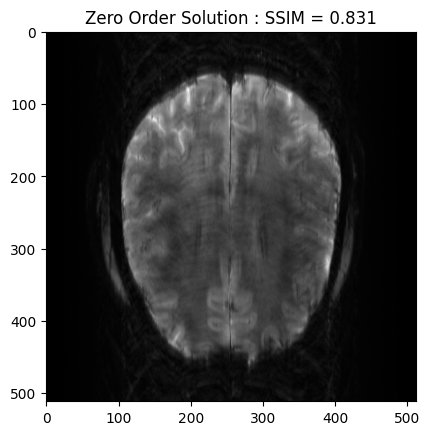

In [3]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(mask=mask, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

# %%
# Zero order solution
zero_soln = np.linalg.norm(fourier_op.adj_op(kspace_obs), axis=0)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

Synthesis formulation: FISTA vs POGM optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [4]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = GroupLASSO(weights=6e-8)

## Setup reconstructor:

In [5]:
# Setup Reconstructor
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1
The lipschitz constraint is satisfied


 - mu:  6e-08
 - lipschitz constant:  1.1
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd47c718c40> - 4
 - max iterations:  100
 - image variable shape:  (512, 512)
 - alpha variable shape:  (32, 291721)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  292.06419773586094  seconds
----------------------------------------


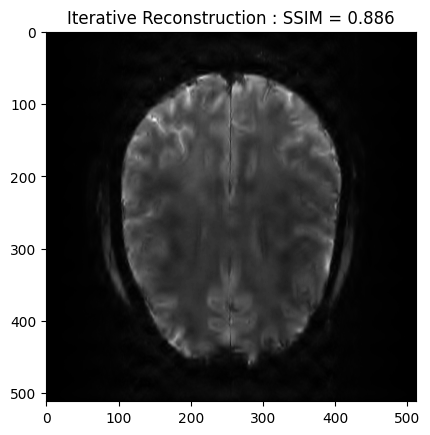

In [6]:
# Run the FISTA reconstruction and view results
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = np.linalg.norm(image_rec, axis=0)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative FISTA Reconstruction : SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM optimization 

 - mu:  6e-08
 - lipschitz constant:  1.1
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd47c718c40> - 4
 - max iterations:  100
 - image variable shape:  (32, 512, 512)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  336.39510036818683  seconds
----------------------------------------


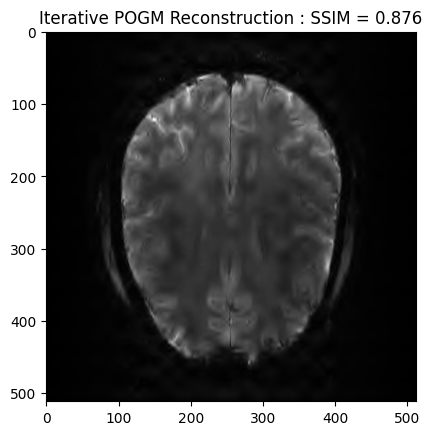

In [7]:
# Run the POGM reconstruction and view results
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=100,
)
image_rec2 = np.linalg.norm(image_rec2, axis=0)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative POGM Reconstruction : SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

In [11]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = OWL(
    alpha=1.05e-8,
    beta=0,
    mode='band_based',
    n_coils=cartesian_ref_image.shape[0],
    bands_shape=linear_op.coeffs_shape,
)
# Setup Reconstructor
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1
The lipschitz constraint is satisfied


 - mu:  [<modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd41c0063b0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd41c007790>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd41d196650>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd41be91a20>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd419517b50>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd4195157b0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd4195178e0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd4195174c0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd419514e50>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd4195177c0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd419515240>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd4195173a0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fd419514100>]
 - lipschitz constant:  1.1
 - data:  (512, 512)
 - wavelet:  <mri.o

  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  537.273373647593  seconds
----------------------------------------


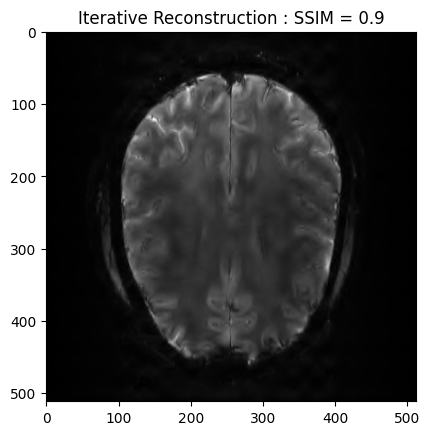

In [12]:
# Run the FISTA reconstruction and view results
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = np.linalg.norm(image_rec, axis=0)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative Reconstruction : SSIM = ' + str(np.around(recon_ssim, 2)))
plt.show()

In [32]:
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
#padding_mode="periodization"

regularizer_op = GroupLASSO(6e-8)

In [33]:
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.1
The lipschitz constraint is satisfied


 - mu:  6e-08
 - lipschitz constant:  1.1
 - tau:  0.9523809433107514
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f0fa8f50f10> - 4
 - max iterations:  100
 - number of reweights:  0
 - primal variable shape:  (32, 512, 512)
 - dual variable shape:  (32, 291721)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:10:51 Time:  0:10:51


 - final iteration number:  100
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  657.6715358300135  seconds
----------------------------------------


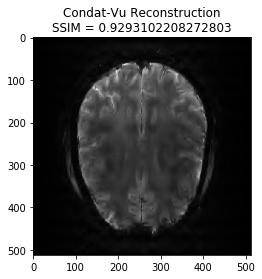

In [34]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=100,
)

image_rec = pysap.Image(data=np.sqrt(np.sum(np.abs(x_final)**2, axis=0)))
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

In [35]:
# Undecimated Wavelets
#linear_op = WaveletUD2(
#    wavelet_id=24,
#    nb_scale=4,
#    n_coils=cartesian_ref_image.shape[0],
#)

In [6]:
#regularizer_op = GroupLASSO(6e-8)
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = OWL(
    alpha=1.05e-8,
    beta=0,
    mode='band_based',
    n_coils=cartesian_ref_image.shape[0],
    bands_shape=linear_op.coeffs_shape,
)

In [7]:
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.1
The lipschitz constraint is satisfied


 - mu:  [<modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb491f31c50>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb491f8fc90>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62090>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62950>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62f90>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62d90>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62250>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62a90>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62110>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62910>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45fc62750>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb491ffa990>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7fb45ff830d0>]
 - lipschitz constant:  1.1
 - tau:  0.9523809433107514
 - sigma:  0

100% (100 of 100) |######################| Elapsed Time: 0:07:40 Time:  0:07:40


 - final iteration number:  100
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  466.3144229580648  seconds
----------------------------------------


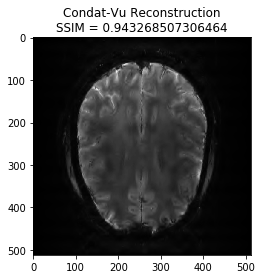

In [8]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=100,
)

image_rec = pysap.Image(data=np.sqrt(np.sum(np.abs(x_final)**2, axis=0)))
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()